# Libs

In [78]:
import pandas as pd
import glob
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense, Masking
import matplotlib
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras_metrics import KerasMetrics
from keras.optimizers import adam
import keras.backend as K
from sklearn.metrics import f1_score
from scipy.spatial import distance
import pickle
import seaborn as sns
import lib
%load_ext autoreload
%autoreload 2
opt = adam()
sns.set_color_codes()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

In [7]:
corpus = pd.read_csv("Corpus_new_coding/423_verbs_with_classes.csv",index_col="Unnamed: 0")

In [71]:
conj_len = corpus.v_conj.apply(lambda x: len(x) - 2)
corpus['conj_len'] = conj_len

In [72]:
corpus

,v_inf,v_conj,class,conj_len
0,preve,$preveju#,class__ver,7
1,anteve,$anteveju#,class__ver,8
2,interve,$interveju#,class__ver,9
3,heve,$heveju#,class__ver,6
4,entreve,$entreveju#,class__ver,9
5,ve,$veju#,class__ver,4
6,entrete,$entreteNu#,class__ter,9
7,obite,$obiteNu#,class__ter,7
8,konte,$konteNu#,class__ter,7
9,ate,$ateNu#,class__ter,5


In [89]:
order3 = corpus.groupby('class').conj_len.mean().sort_values()

In [90]:
order3

class
class__botar      5.000000
class__none       5.650000
class__regular    5.883178
class__cobrir     6.000000
class__ler        6.000000
class__pedir      6.142857
class__seguir     6.370370
class__testar     6.450000
class__ter        6.600000
class__mentir     6.875000
class__ver        7.166667
class__vir        7.181818
class__ansiar     7.333333
class__dizer      7.428571
class__fazer      7.866667
class__por        8.000000
Name: conj_len, dtype: float64

In [4]:
corpus.groupby('class').count().iloc[:,0]

class
class__ansiar       9
class__botar       30
class__cobrir       7
class__dizer        7
class__fazer       15
class__ler          5
class__mentir       8
class__none        20
class__pedir        7
class__por         27
class__regular    214
class__seguir      27
class__ter         10
class__testar      20
class__ver          6
class__vir         11
Name: v_inf, dtype: int64

In [5]:
corpus.groupby('class').count().apply(lambda g: (g / g.sum())*100).iloc[:,0]

class
class__ansiar      2.127660
class__botar       7.092199
class__cobrir      1.654846
class__dizer       1.654846
class__fazer       3.546099
class__ler         1.182033
class__mentir      1.891253
class__none        4.728132
class__pedir       1.654846
class__por         6.382979
class__regular    50.591017
class__seguir      6.382979
class__ter         2.364066
class__testar      4.728132
class__ver         1.418440
class__vir         2.600473
Name: v_inf, dtype: float64

In [6]:
proportions = corpus.groupby('class').count().apply(lambda g: round((g / g.sum())*100, 2)).iloc[:,0]

In [7]:
proportions

class
class__ansiar      2.13
class__botar       7.09
class__cobrir      1.65
class__dizer       1.65
class__fazer       3.55
class__ler         1.18
class__mentir      1.89
class__none        4.73
class__pedir       1.65
class__por         6.38
class__regular    50.59
class__seguir      6.38
class__ter         2.36
class__testar      4.73
class__ver         1.42
class__vir         2.60
Name: v_inf, dtype: float64

# Features

In [4]:
features = lib.features()

In [5]:
len(features)

21

In [6]:
features

['oclusiva',
 'nasal',
 'tepe',
 'fricativa',
 'l-aprox',
 'bilabial',
 'labiodental',
 'alveolar',
 'p-alveolar',
 'palatal',
 'velar',
 'glotal',
 'vozeada',
 'fechada',
 'm-fechada',
 'm-aberta',
 'aberta',
 'anterior',
 'posterior',
 'beg',
 'end']

In [2]:
#http://www.ipachart.com/
with open('Files/phones.pickle', 'rb') as file:
    phones = pickle.load(file)

In [3]:
phones

{'p': ['bilabial', 'oclusiva'],
 'b': ['bilabial', 'oclusiva', 'vozeada'],
 'f': ['labiodental', 'fricativa'],
 'v': ['labiodental', 'fricativa', 'vozeada'],
 't': ['alveolar', 'oclusiva'],
 'd': ['alveolar', 'oclusiva', 'vozeada'],
 'm': ['bilabial', 'nasal'],
 'n': ['alveolar', 'nasal'],
 'k': ['velar', 'oclusiva'],
 'g': ['velar', 'oclusiva', 'vozeada'],
 'N': ['nasal', 'palatal'],
 'r': ['alveolar', 'tepe'],
 's': ['alveolar', 'fricativa'],
 'z': ['alveolar', 'fricativa', 'vozeada'],
 'j': ['p-alveolar', 'fricativa', 'vozeada'],
 'l': ['l-aprox', 'p-alveolar'],
 'L': ['l-aprox', 'palatal'],
 'h': ['glotal', 'fricativa'],
 'x': ['fricativa', 'p-alveolar'],
 'i': ['anterior', 'fechada'],
 'e': ['m-fechada', 'anterior'],
 'E': ['m-aberta', 'anterior'],
 'a': ['anterior', 'aberta'],
 'u': ['posterior', 'fechada'],
 'o': ['m-fechada', 'posterior'],
 'O': ['m-aberta', 'posterior'],
 'A': ['anterior', 'aberta', 'nasal'],
 '3': ['m-fechada', 'anterior', 'nasal'],
 'PAD': [''],
 '#': ['beg'

about pre padding: https://stackoverflow.com/questions/46298793/how-does-choosing-between-pre-and-post-zero-padding-of-sequences-impact-results

# Training

In [136]:
model, decode_from_df, history = lib.train(corpus, epochs=300)

In [121]:
model_big, decode_from_df_big, history_big = lib.train(corpus, epochs=2000)

# F1 Plot, Precision, Recall Plot

## 300 Epochs

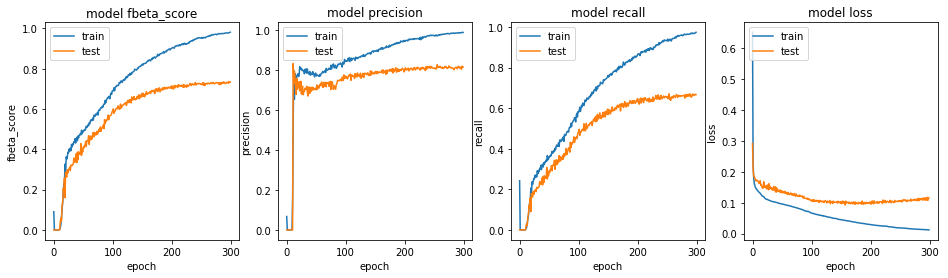

In [122]:
lib.plot_results(history)

In [123]:
history.history['val_fbeta_score'][-1]

0.7332813739776611

In [124]:
history.history['val_recall'][-1]

0.6664310693740845

In [125]:
history.history['val_precision'][-1]

0.8150389194488525

## 2000 Epochs

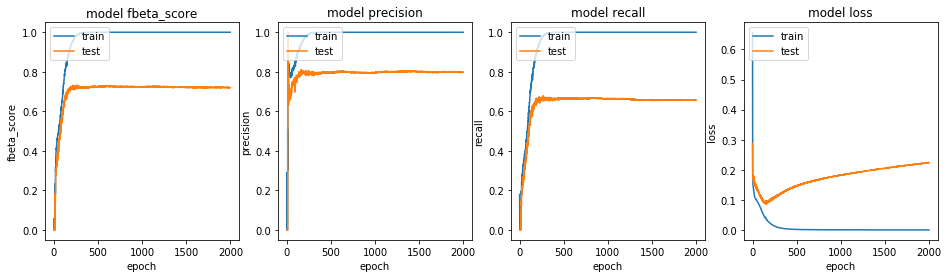

In [126]:
lib.plot_results(history_big)

# KFold Analysis

In [12]:
%time all_decodings = lib.kfold(corpus, n=5)

(333, 3) (90, 3)
(90, 11, 21)
(335, 3) (88, 3)
(88, 10, 21)
(340, 3) (83, 3)
(83, 10, 21)
(341, 3) (82, 3)
(82, 10, 21)
(343, 3) (80, 3)
(80, 10, 21)
CPU times: user 6min 59s, sys: 31.8 s, total: 7min 31s
Wall time: 4min 19s


In [13]:
all_decodings = all_decodings.sort_values('class')

In [14]:
all_decodings.to_csv("Files/all_decodings.csv", index=None)

In [15]:
all_decodings['correct'] = np.where((all_decodings['predicted'] == all_decodings['target']) , 1, 0)

# Learning Curve x Train Size

In [ ]:
all_decodings = lib.kfold(corpus, n=5)

In [30]:
lc = {}
for length in [100, 150, 250, 300, 393]:
    history = train(length)
    lc[length] = history.history['val_fbeta_score'][-1], history.history['recall'][-1], history.history['precision'][-1]

CPU times: user 35min 18s, sys: 3min 47s, total: 39min 5s
Wall time: 11min 20s


In [31]:
lc

{100: (0.5534803867340088, 0.6876574158668518, 0.9181614518165588),
 150: (0.5637180805206299, 0.7294632792472839, 0.9192546606063843),
 250: (0.7961629629135132, 0.8921688175201417, 0.9658581089973449),
 300: (0.7927590012550354, 0.9350285490353902, 0.9777678648630778),
 393: (0.7852533459663391, 0.9763083427574983, 0.9875784125297692)}

with open('WickelfeaturesProject/Files/learning_curve.pickle', 'wb') as file:
    pickle.dump(lc, file, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('WickelfeaturesProject/Files/lc.pickle', 'rb') as file:
    lc = pickle.load(file)

# Mult Kfold

## Training

In [25]:
%time lib.mult_kfold(corpus, n=5, renorm=False, num=30)

(333, 3) (90, 3)
(335, 3) (88, 3)
(340, 3) (83, 3)
(341, 3) (82, 3)
(343, 3) (80, 3)
(333, 3) (90, 3)
(335, 3) (88, 3)
(340, 3) (83, 3)
(341, 3) (82, 3)
(343, 3) (80, 3)
(333, 3) (90, 3)
(335, 3) (88, 3)
(340, 3) (83, 3)
(341, 3) (82, 3)
(343, 3) (80, 3)
(333, 3) (90, 3)
(335, 3) (88, 3)
(340, 3) (83, 3)
(341, 3) (82, 3)
(343, 3) (80, 3)
(333, 3) (90, 3)
(335, 3) (88, 3)
(340, 3) (83, 3)
(341, 3) (82, 3)
(343, 3) (80, 3)
(333, 3) (90, 3)
(335, 3) (88, 3)
(340, 3) (83, 3)
(341, 3) (82, 3)
(343, 3) (80, 3)
(333, 3) (90, 3)
(335, 3) (88, 3)
(340, 3) (83, 3)
(341, 3) (82, 3)
(343, 3) (80, 3)
(333, 3) (90, 3)
(335, 3) (88, 3)
(340, 3) (83, 3)
(341, 3) (82, 3)
(343, 3) (80, 3)
(333, 3) (90, 3)
(335, 3) (88, 3)
(340, 3) (83, 3)
(341, 3) (82, 3)
(343, 3) (80, 3)
(333, 3) (90, 3)
(335, 3) (88, 3)
(340, 3) (83, 3)
(341, 3) (82, 3)
(343, 3) (80, 3)
(333, 3) (90, 3)
(335, 3) (88, 3)
(340, 3) (83, 3)
(341, 3) (82, 3)
(343, 3) (80, 3)
(333, 3) (90, 3)
(335, 3) (88, 3)
(340, 3) (83, 3)
(341, 3) (82, 

##  Analysis

In [43]:
path = r'Kfold' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, header=0)
    df['fold'] = filename
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=False)

In [44]:
frame

,class,correct,total,accuracy,proportion_in_corpus,fold
0,class__ansiar,0,9,0.00,2.13,Kfold/accuracys_kfold_iter_0.csv
1,class__botar,5,30,0.17,7.09,Kfold/accuracys_kfold_iter_0.csv
2,class__cobrir,1,7,0.14,1.65,Kfold/accuracys_kfold_iter_0.csv
3,class__dizer,0,7,0.00,1.65,Kfold/accuracys_kfold_iter_0.csv
4,class__fazer,3,15,0.20,3.55,Kfold/accuracys_kfold_iter_0.csv
5,class__ler,0,5,0.00,1.18,Kfold/accuracys_kfold_iter_0.csv
6,class__mentir,1,8,0.12,1.89,Kfold/accuracys_kfold_iter_0.csv
7,class__none,0,20,0.00,4.73,Kfold/accuracys_kfold_iter_0.csv
8,class__pedir,0,7,0.00,1.65,Kfold/accuracys_kfold_iter_0.csv
9,class__por,0,27,0.00,6.38,Kfold/accuracys_kfold_iter_0.csv


In [17]:
order1 = frame.groupby('class').mean().round(2).sort_values('proportion_in_corpus', ascending=False).index.values
order2 = frame.groupby('class').mean().round(2).sort_values('accuracy', ascending=False).index.values

In [166]:
new = frame.groupby('class').std().round(2)

### Accuracy ordered by proportion in corpus

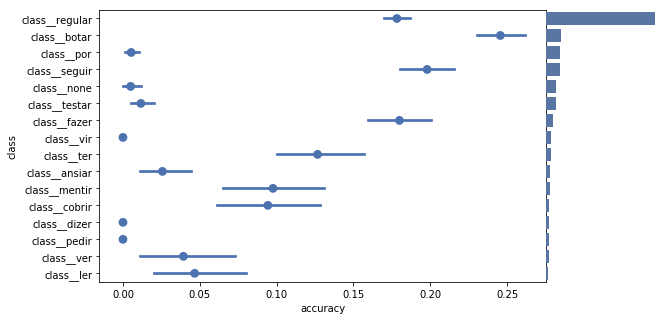

In [121]:
fig = plt.figure(figsize=(8, 5))
ax1 = sns.pointplot(y='class', x='accuracy', data=frame, join=False, scale=1, orient='h', order=order1, color='b')
bb = ax1.get_position()
ax = fig.add_axes([bb.max[0],bb.min[1],.2,bb.height])
sns.barplot(x='total', y='class', data=frame, order=order1, color='b')
ax.set_axis_off()
# ax.set_yticks([]); ax.

### Accuracy

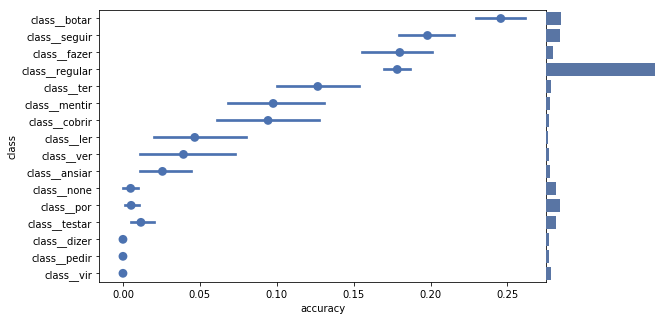

In [135]:
fig = plt.figure(figsize=(8, 5))
ax1 = sns.pointplot(y='class', x='accuracy', data=frame, join=False, scale=1, orient='h', order=order2, color='b')
bb = ax1.get_position()
ax = fig.add_axes([bb.max[0],bb.min[1],.2,bb.height])
sns.barplot(x='total', y='class', data=frame, order=order2, color='b')
ax.set_axis_off()

In [100]:
frame.drop(['len_conj'], axis=1)

,class,correct,total,accuracy,proportion_in_corpus,fold
0,class__ansiar,0,9,0.00,2.13,Kfold/accuracys_kfold_iter_0.csv
1,class__botar,5,30,0.17,7.09,Kfold/accuracys_kfold_iter_0.csv
2,class__cobrir,1,7,0.14,1.65,Kfold/accuracys_kfold_iter_0.csv
3,class__dizer,0,7,0.00,1.65,Kfold/accuracys_kfold_iter_0.csv
4,class__fazer,3,15,0.20,3.55,Kfold/accuracys_kfold_iter_0.csv
5,class__ler,0,5,0.00,1.18,Kfold/accuracys_kfold_iter_0.csv
6,class__mentir,1,8,0.12,1.89,Kfold/accuracys_kfold_iter_0.csv
7,class__none,0,20,0.00,4.73,Kfold/accuracys_kfold_iter_0.csv
8,class__pedir,0,7,0.00,1.65,Kfold/accuracys_kfold_iter_0.csv
9,class__por,0,27,0.00,6.38,Kfold/accuracys_kfold_iter_0.csv


In [101]:
order3 = corpus.groupby('class').conj_len.mean().sort_values(ascending=True).index.values

In [108]:
corpus.groupby('class').conj_len.mean().sort_values(ascending=True)

class
class__botar      5.000000
class__none       5.650000
class__regular    5.883178
class__cobrir     6.000000
class__ler        6.000000
class__pedir      6.142857
class__seguir     6.370370
class__testar     6.450000
class__ter        6.600000
class__mentir     6.875000
class__ver        7.166667
class__vir        7.181818
class__ansiar     7.333333
class__dizer      7.428571
class__fazer      7.866667
class__por        8.000000
Name: conj_len, dtype: float64

In [102]:
order3

array(['class__botar', 'class__none', 'class__regular', 'class__cobrir',
       'class__ler', 'class__pedir', 'class__seguir', 'class__testar',
       'class__ter', 'class__mentir', 'class__ver', 'class__vir',
       'class__ansiar', 'class__dizer', 'class__fazer', 'class__por'],
      dtype=object)

### Accuracy ordered by ascending mean len

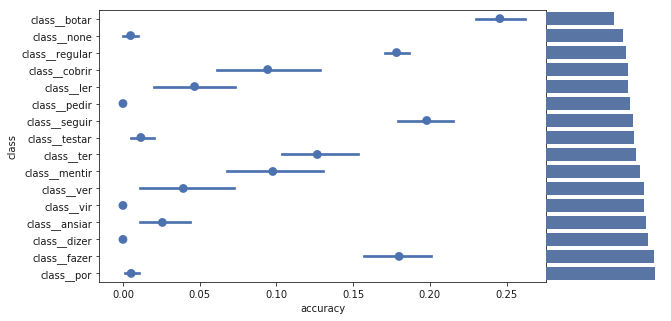

In [107]:
fig = plt.figure(figsize=(8, 5))
ax1 = sns.pointplot(y='class', x='accuracy', data=frame, join=False, scale=1, orient='h', order=order3, color='b')
bb = ax1.get_position()
ax = fig.add_axes([bb.max[0],bb.min[1],.2,bb.height])
sns.barplot(x='conj_len', y='class', data=corpus, ci=None, order=order3, color='b')
ax.set_axis_off()

# Best Accuracy File

In [203]:
path = r'Kfold' # use your path
all_files = glob.glob(path + "/*.csv")

li = []
sum_ = 0
for filename in all_files:
    df = pd.read_csv(filename, header=0)
    if df.correct.sum() > sum_:
        best = filename
        sum_ = df.correct.sum()
        
best_accuracy = pd.read_csv(best)
best_accuracy.correct.sum()/best_accuracy.total.sum()

62 Kfold/accuracys_kfold_iter_16.csv
73 Kfold/accuracys_kfold_iter_5.csv


'Kfold/accuracys_kfold_iter_5.csv'

In [207]:
best_accuracy.correct.sum()

73

In [206]:
best_accuracy

,class,correct,total,accuracy,proportion_in_corpus
0,class__ansiar,1,9,0.11,2.13
1,class__botar,9,30,0.30,7.09
2,class__cobrir,1,7,0.14,1.65
3,class__dizer,0,7,0.00,1.65
4,class__fazer,1,15,0.07,3.55
5,class__ler,0,5,0.00,1.18
6,class__mentir,2,8,0.25,1.89
7,class__none,0,20,0.00,4.73
8,class__pedir,0,7,0.00,1.65
9,class__por,1,27,0.04,6.38


# Results 

In [208]:
best_accuracy.correct.sum()

73

In [224]:
best_accuracy = best_accuracy.set_index('class')

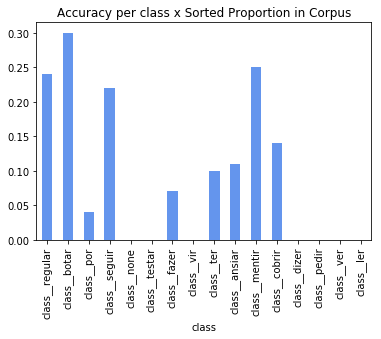

In [219]:
best_accuracy.sort_values('proportion_in_corpus', ascending=False)\
.accuracy.plot.bar(color='cornflowerblue', title='Accuracy per class x Sorted Proportion in Corpus')

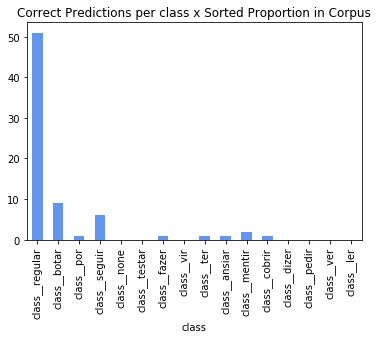

In [220]:
best_accuracy.sort_values('proportion_in_corpus', ascending=False)\
.correct.plot.bar(color='cornflowerblue', title='Correct Predictions per class x Sorted Proportion in Corpus')

## Homogeneity among classes 

In [221]:
perplexity = corpus.groupby('class').v_conj.apply(lib.perplexity)

In [225]:
best_accuracy['perplexity'] = perplexity
best_accuracy.sort_values('perplexity')

,correct,total,accuracy,proportion_in_corpus,perplexity
class,,,,,
class__regular,51,214,0.24,50.59,1.003667
class__por,1,27,0.04,6.38,1.021651
class__seguir,6,27,0.22,6.38,1.027298
class__botar,9,30,0.30,7.09,1.031391
class__testar,0,20,0.00,4.73,1.036635
class__fazer,1,15,0.07,3.55,1.040148
class__none,0,20,0.00,4.73,1.041978
class__vir,0,11,0.00,2.60,1.060829
class__ansiar,1,9,0.11,2.13,1.073437


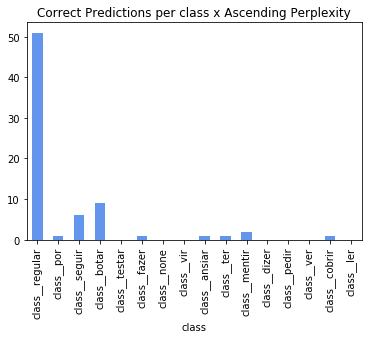

In [228]:
best_accuracy.sort_values('perplexity', ascending=True)\
.correct.plot.bar(color='cornflowerblue', title='Correct Predictions per class x Ascending Perplexity')

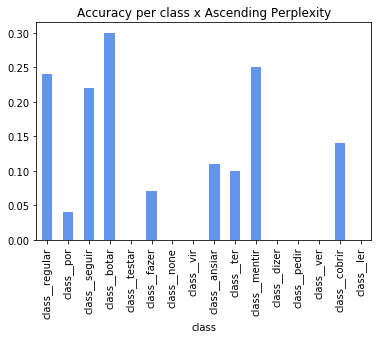

In [229]:
best_accuracy.sort_values('perplexity', ascending=True)\
.accuracy.plot.bar(color='cornflowerblue', title='Accuracy per class x Ascending Perplexity')

In [2]:
import pickle
with open('Files/phones.pickle', 'rb') as file:
    phones = pickle.load(file)
phones

{'p': ['bilabial', 'oclusiva'],
 'b': ['bilabial', 'oclusiva', 'vozeada'],
 'f': ['labiodental', 'fricativa'],
 'v': ['labiodental', 'fricativa', 'vozeada'],
 't': ['alveolar', 'oclusiva'],
 'd': ['alveolar', 'oclusiva', 'vozeada'],
 'm': ['bilabial', 'nasal'],
 'n': ['alveolar', 'nasal'],
 'k': ['velar', 'oclusiva'],
 'g': ['velar', 'oclusiva', 'vozeada'],
 'N': ['nasal', 'palatal'],
 'r': ['alveolar', 'tepe'],
 's': ['alveolar', 'fricativa'],
 'z': ['alveolar', 'fricativa', 'vozeada'],
 'j': ['p-alveolar', 'fricativa', 'vozeada'],
 'l': ['l-aprox', 'p-alveolar'],
 'L': ['l-aprox', 'palatal'],
 'h': ['glotal', 'fricativa'],
 'x': ['fricativa', 'p-alveolar'],
 'i': ['anterior', 'fechada'],
 'e': ['m-fechada', 'anterior'],
 'E': ['m-aberta', 'anterior'],
 'a': ['anterior', 'aberta'],
 'u': ['posterior', 'fechada'],
 'o': ['m-fechada', 'posterior'],
 'O': ['m-aberta', 'posterior'],
 'A': ['anterior', 'aberta', 'nasal'],
 '3': ['m-fechada', 'anterior', 'nasal'],
 'PAD': [''],
 '#': ['beg'